## Loading The Dataset

In [87]:
import pandas as pd
import psycopg2

In [88]:
db_config = {
    "host": "branchhomeworkdb.cv8nj4hg6yra.ap-south-1.rds.amazonaws.com",
    "database": "branchdsprojectgps",
    "user": "datascientist",
    "password": "47eyYBLT0laW5j9U24Uuy8gLcrN",
    "port": "5432"
}

In [89]:
conn = psycopg2.connect(**db_config)


In [90]:
loan_outcomes = pd.read_sql("SELECT * FROM loan_outcomes", conn)
gps_fixes = pd.read_sql("SELECT * FROM gps_fixes", conn)
user_attributes = pd.read_sql("SELECT * FROM user_attributes", conn)

C:\Users\Adityavardhan Jain\AppData\Local\Temp\ipykernel_17072\2373577388.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  loan_outcomes = pd.read_sql("SELECT * FROM loan_outcomes", conn)
C:\Users\Adityavardhan Jain\AppData\Local\Temp\ipykernel_17072\2373577388.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  gps_fixes = pd.read_sql("SELECT * FROM gps_fixes", conn)
C:\Users\Adityavardhan Jain\AppData\Local\Temp\ipykernel_17072\2373577388.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  user_attributes = pd.read_sql

In [91]:
conn.close()


In [92]:
print(loan_outcomes.head())
print(gps_fixes.head())
print(user_attributes.head())

   user_id             application_at loan_outcome
0        1 2017-08-14 09:08:50.000000    defaulted
1        2 2016-05-17 10:10:12.447976       repaid
2        3 2016-10-20 10:07:20.459081    defaulted
3        4 2017-01-13 13:03:34.000000    defaulted
4        5 2016-11-03 15:41:39.124610       repaid
           gps_fix_at    server_upload_at  longitude  latitude  accuracy  \
0 2017-06-22 09:37:20 2017-06-22 09:43:42  36.840540 -1.294342      68.4   
1 2017-08-14 07:50:27 2017-08-14 09:05:27  36.895270 -1.341928    1409.0   
2 2017-06-13 10:34:29 2017-06-13 10:54:48  36.811903 -1.307220      68.4   
3 2017-06-18 12:16:20 2017-06-18 12:16:24  36.907049 -1.309984    1581.0   
4 2017-06-28 09:39:08 2017-06-28 09:58:12  36.839396 -1.280310    1396.0   

   altitude  bearing location_provider  user_id  
0       0.0      0.0             fused        1  
1       0.0      0.0             fused        1  
2       0.0      0.0             fused        1  
3       0.0      0.0             fuse

## EDA and Feature Engineering

In [93]:
print("Missing values in loan_outcomes:")
print(loan_outcomes.isnull().sum())

print("\nMissing values in gps_fixes:")
print(gps_fixes.isnull().sum())

print("\nMissing values in user_attributes:")
print(user_attributes.isnull().sum())

Missing values in loan_outcomes:
user_id           0
application_at    0
loan_outcome      0
dtype: int64

Missing values in gps_fixes:
gps_fix_at           0
server_upload_at     0
longitude            0
latitude             0
accuracy             0
altitude             0
bearing              0
location_provider    0
user_id              0
dtype: int64

Missing values in user_attributes:
user_id                 0
age                     0
cash_incoming_30days    0
dtype: int64


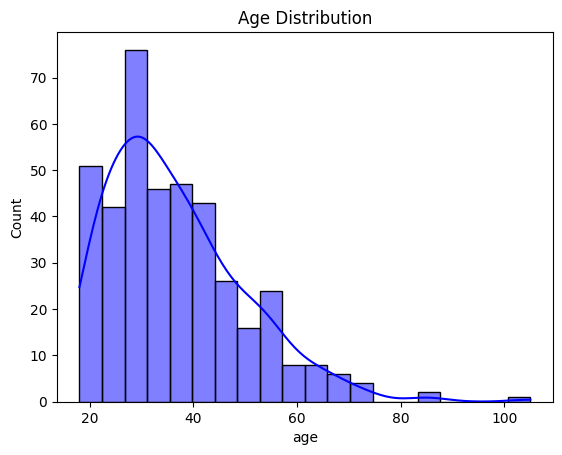

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(user_attributes['age'], bins=20, kde=True, color='blue')
plt.title("Age Distribution")
plt.show()



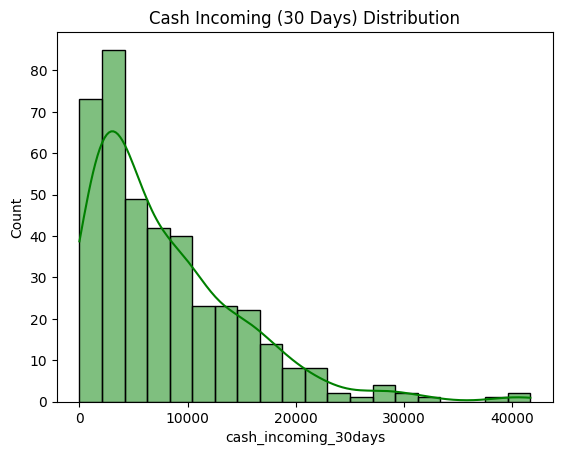

In [95]:
sns.histplot(user_attributes['cash_incoming_30days'], bins=20, kde=True, color='green')
plt.title("Cash Incoming (30 Days) Distribution")
plt.show()


In [96]:
gps_count = gps_fixes.groupby('user_id')['latitude'].count().reset_index()
gps_count.rename(columns={'latitude': 'gps_fix_count'}, inplace=True)

In [97]:
gps_accuracy = gps_fixes.groupby('user_id')['accuracy'].mean().reset_index()
gps_accuracy.rename(columns={'accuracy': 'avg_gps_accuracy'}, inplace=True)

In [98]:
gps_provider = gps_fixes.groupby('user_id')['location_provider'].agg(lambda x: x.mode()[0]).reset_index()
gps_provider.rename(columns={'location_provider': 'most_common_provider'}, inplace=True)

In [99]:
features = loan_outcomes.merge(user_attributes, on='user_id', how='left')
features = features.merge(gps_count, on='user_id', how='left')
features = features.merge(gps_accuracy, on='user_id', how='left')
features = features.merge(gps_provider, on='user_id', how='left')
features.drop(columns=['user_id'], inplace=True)
print(features.head())


              application_at loan_outcome  age  cash_incoming_30days  \
0 2017-08-14 09:08:50.000000    defaulted   42               8988.12   
1 2016-05-17 10:10:12.447976       repaid   36               9968.12   
2 2016-10-20 10:07:20.459081    defaulted   27                 59.04   
3 2017-01-13 13:03:34.000000    defaulted   38               2129.03   
4 2016-11-03 15:41:39.124610       repaid   33               2102.53   

   gps_fix_count  avg_gps_accuracy most_common_provider  
0           70.0       1105.084571                fused  
1           10.0         48.596000                fused  
2            1.0          6.500000                  gps  
3            2.0       2172.200000                fused  
4            9.0         43.461111                fused  


In [100]:
features = pd.get_dummies(features, columns=['most_common_provider'], drop_first=True)

In [101]:
features['loan_outcome'] = features['loan_outcome'].map({'repaid': 1, 'defaulted': 0})

In [102]:
print("Target variable distribution:")
print(features['loan_outcome'].value_counts())


Target variable distribution:
loan_outcome
0    200
1    200
Name: count, dtype: int64


In [103]:
datetime_columns = features.select_dtypes(include=['datetime64']).columns
print("Datetime columns:", datetime_columns)


Datetime columns: Index(['application_at'], dtype='object')


In [104]:
features['application_timestamp'] = features['application_at'].astype('int64') // 10**9


In [105]:
print(features.dtypes)

application_at                  datetime64[ns]
loan_outcome                             int64
age                                      int64
cash_incoming_30days                   float64
gps_fix_count                          float64
avg_gps_accuracy                       float64
most_common_provider_gps                  bool
most_common_provider_network              bool
application_timestamp                    int64
dtype: object


In [106]:
features.drop(columns=['application_at'], inplace=True)

## Model Training

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X = features.drop(columns=['loan_outcome'])  
y = features['loan_outcome']                

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [110]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (320, 7)
Testing data shape: (80, 7)


In [111]:
from sklearn.ensemble import RandomForestClassifier


In [112]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


In [113]:
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## Model Evaluation

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


In [115]:
y_pred = rf_model.predict(X_test)

In [116]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.76
Precision: 0.83
Recall: 0.70


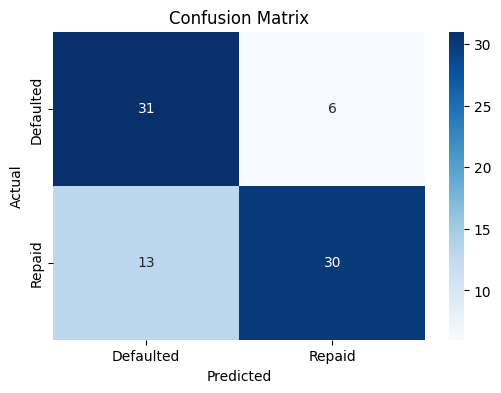

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Defaulted', 'Repaid'], yticklabels=['Defaulted', 'Repaid'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Saving the Model and Feature Importance

In [118]:
import pickle
with open('model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

print("Model saved to model.pkl!")


Model saved to model.pkl!


In [119]:
importances = rf_model.feature_importances_
feature_names = X.columns



C:\Users\Adityavardhan Jain\AppData\Local\Temp\ipykernel_17072\1676367824.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


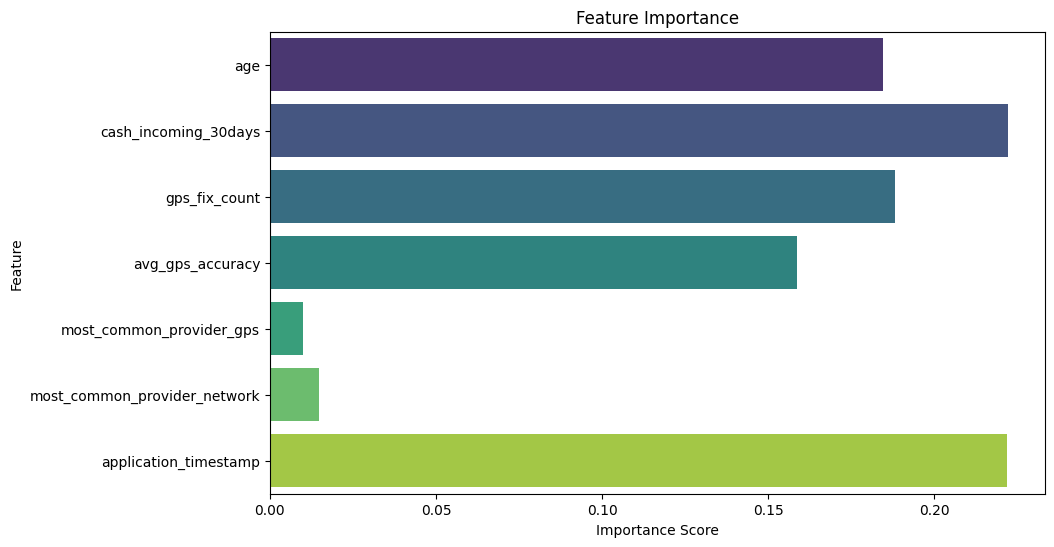

In [120]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
